## TODO:
 * Introduce notion of "film quality": determines the base value of ratings
 * Give each user a baseline rating: to emulate how some users rate higher than others
 * Implement different user behaviors in response to recommendations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.sparse.linalg import svds
from IPython.display import display

## Setup

We have two types of movies, type 1 and type 2. Each movie has a vector assciotated with them, [x,y]. x and y are binary variables with possible values of 0 and 1. x = 1 means that the film is of type 1, and y = 1 means that the film is of type2.
Each user also has a hidden vector associated with him or her, [b,c], where b and c are preferences for type 1 and type 2 films respectively. $0 \leq b,c \leq 1$ and $b + c = 1$. If a user's perference for a type of film is [a,b], then this user has $a$ chance of accepting recommendations of films of type 1 and $b$ chance of accepting recommendations of films of type 2. This user will rate a film of type 1: $a*5 $

In [2]:
MAX_RATING = 5 # 5

quality_lower_bound = MAX_RATING / 3.0
quality_upper_bound = 2 * MAX_RATING / 3.0

# Generate a user matrix, where each row of the
# matrix stores the properties of a user:
# [type1_preference, type2_preference]
def generate_Users(number_of_users):
    result = []
    for i in range(number_of_users):
        a = random.uniform(0,1)
        result.append([a, 1-a])
    return(np.array(result))

# Generate a film matrix, where each row of the
# matrix represents the properties of a film:
# [is_type1, is_type2, quality]
def generate_Films(number_of_films):
    result = []
    for i in range(number_of_films):
        a = random.randint(0,1)
        quality = random.uniform(quality_lower_bound, quality_upper_bound)
        result.append([a, 1-a, quality])
    return(np.array(result))

In [3]:
# Generates num_films x num_users rating matrix, where
# each row represents the ratings that film has received
# from all users.
# Percentage is the chance a user will view a given film
def generate_initial_ratings(films, users, percentage):
    num_films = films.shape[0]
    film_list = films.tolist()
    user_list = users.tolist()
    results = []
    for film in film_list:
        ratings = []
        for user in user_list:
            ran = random.uniform(0,1)
            if (ran <= percentage):
                t = MAX_RATING * (user[0]*film[0] + user[1]*film[1])
                if t == 0:
                    t = 5.0 * random.uniform(0.1,1)
                ratings.append(t)
            else:
                ratings.append(0)
        results.append(ratings)
    return(np.array(results))

In [4]:
NUM_USERS = 6040 # 6040
NUM_FILMS = 3883 # 3883
INITIAL_RATING_RATE = 0.05 # 0.05

users = generate_Users(NUM_USERS)
films = generate_Films(NUM_FILMS)
initial_ratings = generate_initial_ratings(films, users, INITIAL_RATING_RATE)

display(initial_ratings)
print(initial_ratings.shape)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.84509123,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.54523698, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

(3883, 6040)


In [5]:
NUM_SVALS = 10 # 50

# Returns a num_users x num_films matrix containing
# the predicted ratings each user would give each film
def get_predicted_ratings(actual_ratings):
    # Only consider non-zero ratings when calculating the mean
    masked_user_ratings = np.ma.masked_equal(initial_ratings.T, 0)
    user_ratings_mean = masked_user_ratings.mean(axis=1).data
    # Calculate SVD values of demeaned ratings + estimate new ratings
    R_demeaned = actual_ratings.T - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k=NUM_SVALS)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.round(np.dot(np.dot(U, sigma), Vt) +
            user_ratings_mean.reshape(-1, 1))
    return all_user_predicted_ratings

example_predictions = get_predicted_ratings(initial_ratings)
display(example_predictions)
print(example_predictions.shape)

array([[ 0.,  0., -0., ..., -0., -0.,  0.],
       [ 0., -0., -0., ..., -0., -0., -0.],
       [-0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., -0., -0.],
       [ 0.,  0., -0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

(6040, 3883)


Question: Should we also recommend videos that users have already viewed? At least for me, Youtube recommends videos that I have already watched all the time.

In [6]:
# Returns the IDs of the top num_recommendations
# film recommendations for the provided user
def get_recommendations(predicted_ratings, userID, num_recommendations=5):
    predicted_user_ratings = predicted_ratings[userID]
    recommendations = np.argsort(predicted_user_ratings)[-num_recommendations:]
    return recommendations

example_recs = get_recommendations(example_predictions, 0)
display(example_recs)

array([ 780, 2360,  784, 3860, 3265])

## Run the Simulation:

In [7]:
initial_predictions = get_predicted_ratings(initial_ratings)

In [8]:
# Recommends films to the user, and returns a tuple
# containing the recommended film IDs, and counts
# of the recommendations received of each film type
def give_recommendations(predicted_ratings, userID):
    recommended_filmIDs = get_recommendations(predicted_ratings, userID).tolist()
    film_recs = films[recommended_filmIDs, :]
    num_type1_films = int(sum(film_recs[:, 0]))
    num_type2_films = int(sum(film_recs[:, 1]))
    return (recommended_filmIDs, [num_type1_films, num_type2_films])

# A num_users x num_types matrix where each row
# is the number of recommendations that user has
# received of each film type
initial_distribution_matrix = []

# Get the initial recommendation type counts
for userID in range(users.shape[0]):
    (recommended_filmIDs, type_counts) = give_recommendations(initial_predictions, userID)
    initial_distribution_matrix.append(type_counts)

display(initial_distribution_matrix[:10])

[[5, 0],
 [5, 0],
 [3, 2],
 [3, 2],
 [3, 2],
 [3, 2],
 [3, 2],
 [3, 2],
 [3, 2],
 [2, 3]]

In [9]:
# Runs one step of the simulation:
# Gives new recommendations to each user, and simulates them
# viewing + rating a random selection of them.
# Returns the new rating matrix, the new distribution matrix of
# recommended film types, and the # of changes in this matrix
def step_simulation(actual_ratings, predicted_ratings, rec_type_counts):
    new_ratings = actual_ratings.copy()
    new_distribution_matrix = []
    num_distribution_changes = 0
    
    for userID in range(users.shape[0]):
        user = users[userID]
        (recommended_filmIDs, new_type_counts) = \
                give_recommendations(predicted_ratings, userID)
        new_distribution_matrix.append(new_type_counts)
        
        # Check for changes in the user's recommendation distribution
        if (new_type_counts[0] != rec_type_counts[userID][0]) or \
                (new_type_counts[1] != rec_type_counts[userID][1]):
            num_distribution_changes += 1
        
        # Determine whether the user will watch each
        # recommended film, and assign a rating if so
        for filmID in recommended_filmIDs:
            film_type = 0 if films[filmID][0] == 1 else 1
            ran = random.uniform(0,1)
            if ran <= user[film_type]:
                film_ratings = actual_ratings[:, filmID]
                mean_rating = np.mean(film_ratings[film_ratings.nonzero()])
                rating = min(round(mean_rating + user[film_type]), 5)
                new_ratings[filmID, userID] = rating

    return (new_ratings, new_distribution_matrix, num_distribution_changes)

In [10]:
MAX_STEPS = 200
CHANGE_THRESHOLD = 0

ratings = initial_ratings.copy()
predictions = initial_predictions.copy()
rec_distribution = list(initial_distribution_matrix)
num_changes_over_time = []

for step in range(MAX_STEPS):
    predictions = get_predicted_ratings(ratings)
    ratings, rec_distribution, num_changes = step_simulation(ratings,
            predictions, rec_distribution)
    num_changes_over_time.append(num_changes)
    if step > 0 and num_changes <= CHANGE_THRESHOLD:
        print("Convergence!")
        break
    print("Step #%d: Num Changes = %d" % (step, num_changes))

Step #0: Num Changes = 0
Step #1: Num Changes = 1674
Step #2: Num Changes = 2258
Step #3: Num Changes = 1293
Step #4: Num Changes = 715
Step #5: Num Changes = 525
Step #6: Num Changes = 440
Step #7: Num Changes = 328
Step #8: Num Changes = 265
Step #9: Num Changes = 237
Step #10: Num Changes = 177
Step #11: Num Changes = 176
Step #12: Num Changes = 133
Step #13: Num Changes = 140
Step #14: Num Changes = 136
Step #15: Num Changes = 132
Step #16: Num Changes = 97
Step #17: Num Changes = 83
Step #18: Num Changes = 60
Step #19: Num Changes = 49
Step #20: Num Changes = 48
Step #21: Num Changes = 48
Step #22: Num Changes = 43
Step #23: Num Changes = 34
Step #24: Num Changes = 35
Step #25: Num Changes = 25
Step #26: Num Changes = 18
Step #27: Num Changes = 21
Step #28: Num Changes = 7
Step #29: Num Changes = 14
Step #30: Num Changes = 18
Step #31: Num Changes = 10
Step #32: Num Changes = 7
Step #33: Num Changes = 11
Step #34: Num Changes = 8
Step #35: Num Changes = 4
Step #36: Num Changes = 6

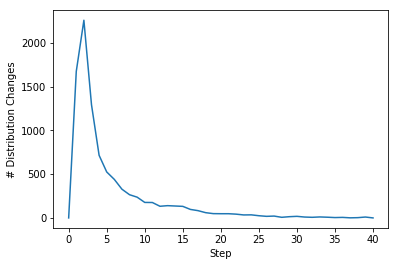

In [11]:
# Plot the recommendation distribution changes over time
plt.plot(num_changes_over_time)
plt.xlabel("Step")
plt.ylabel("# Distribution Changes")
plt.show()